In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [3]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [8]:
def read_voc_images(voc_dir, is_train=True):
    """ 读取所有VOC图像和标注 """
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 
                             'train.txt' if is_train else 'val.txt')    # 保存的图像名字，没有扩展
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []   # features保存读取的图片内容，labels保存读取的标记内容
    
    for i, fname in enumerate(images):
        img = os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')
        label = os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png')
        
        img = torchvision.io.read_image(img)        # CHW RGB
        label = torchvision.io.read_image(label, mode)      # CHW 
        # print(f'$$$ img.shape {img.shape}, label.shape {label.shape}')
        features.append(img)
        labels.append(label)
    return features, labels

train_features, train_labels  = read_voc_images(voc_dir, True)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

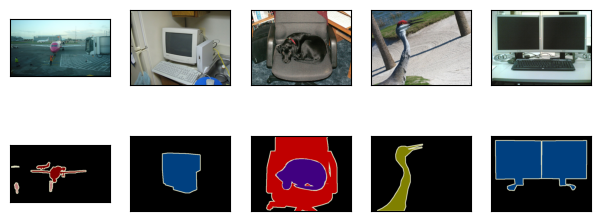

In [12]:
# 显示前5个图像和标签
n = 5
imgs = train_features[:n] + train_labels[:n]
imgs = [img.permute(1, 2, 0) for img in imgs]   # CHW-->HWC
d2l.show_images(imgs, 2, n)     # 此函数展示图像需使用 HWC


In [13]:
# 列举RGB颜色值和类名;
# 即通过像素值定义像素类别
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']
print(f'we have {len(VOC_COLORMAP)} colors, {len(VOC_CLASSES)} classes.')

we have 21 colors, 21 classes.


In [14]:
def voc_colormap2label():
    """ 构建 R+G+B --> VOC类别索引 的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)    # 整数类型
    for i, colormap in enumerate(VOC_COLORMAP):     # 遍历像素值
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]
        ] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """ colormap:多组RGB值\n
        return:多组RGB值对应的VOC类别索引 """
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    return colormap2label[idx]

In [18]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]     # train_labels[0]样本中每个像素的类别，代表的类别名称

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

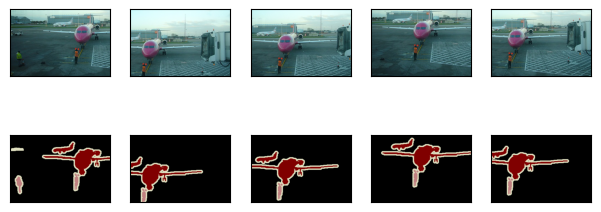

In [21]:
def voc_rand_crop(feature, label, height, width):
    """ 随机裁剪特征和标签 """
    rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))   # 返回目标裁剪区域矩形的 左上坐标 和 宽、高
    # 使用相同参数 rect，就能保证裁剪图片和标签的相同区域
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)     # 对同一个 图片and标签 裁剪n次
imgs = [img.permute(1, 2, 0) for img in imgs]       # CHW --> HWC
d2l.show_images(imgs[::2] + imgs[1::2], 2, n)       # 代码很妙，::2刚好把图片和标签分隔开

In [26]:
class VOCSegDataset(torch.utils.data.Dataset):
    """ 一个加载VOC数据集的自定义数据集\n
        Q：个人感觉features和labels索引可能不匹配？——是匹配的，都经过了filter()过滤，只不过features又多了一步标准化 """
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[.485, .456, .406],
            std=[.229, .224,.225]
        )
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature) for feature in self.filter(features)]
        self.labels = self.filter(labels)       # labels都留着？但features可能过滤掉一部分
        self.colormap2label = voc_colormap2label()      # R+B+G --> VOC类别索引
        
        print(f'read {len(self.features)} examples. ')
        
    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and 
            img.shape[2] >= self.crop_size[1]
        )]
    
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))
    
    def __len__(self):
        return len(self.features)

In [27]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples. 
read 1078 examples. 


In [29]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True, drop_last=True, num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(f'X.shape {X.shape}\nY.shape {Y.shape}')
    break

X.shape torch.Size([64, 3, 320, 480])
Y.shape torch.Size([64, 320, 480])


In [30]:
def load_data_voc(batch_size, crop_size):
    """ 下载、读取VOC，返回train_iter、test_iter """
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'
    ))
    num_workers = d2l.get_dataloader_workers()
    train_dataset = VOCSegDataset(True, crop_size, voc_dir)
    test_dataset = VOCSegDataset(False, crop_size, voc_dir)
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, drop_last=True, num_workers=num_workers)
    return train_iter, test_iter